# Backpropagation in CNN

We will implement a simple CNN to classify a generated image into one of two classes: rectangles or crosses. This notebook will guide you through the given/find exercise, and will perform exacly one forward/backward pass through the CNN. A full implementation with training and testing of the network is profided in the CNNs.py file. This demonstrates that the solution in fact works, and achieves a high score in testing.
#### Given: Architecture of the CNN
Input: One channel (5x5) matrix with random values np.random.uniform(0, 1) arranged in shape of either a cross or a rectangle according to the indices in cross_indices or rectangle indices.

Convolution: Convolutional layer with kernel size=(3, 3), stride=1, padding=0, that uses ReLU as activation function. Upon initialization, bias=1 and kernel weights are initialized as np.random.uniform(0, 1, (3,3))

Pooling: Max Pooling with kernel size=(2, 2), stride=2

Fully connected layer: input layer size = (4, 1). Uses the logistic Sigmoid function as activation function in the output layer.

#### Find

1. Size of the outputs for the convolution- and the pooling layer.
2. Values of outputs of each layer before an eventual application of the output activation function during forward propagation.
3. Gradient of the loss function wrt. kernel weights in the convolutional layer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#### HELPER FUNCTIONS AND DATASTRUCTURES ####
conv_vars = {
    'conv_padding': 0, 
    'conv_stride': 1,
    'conv_kernel': np.random.uniform(0, 1, (3,3)),  # convolution kernel
    'conv_bias': 1,  # bias for convolution layer
    'kernel_pool_size': 2,
    'kernel_pool_stride': 1,
    'weights_fc': np.random.uniform(0, 1, 4),  # weights for fully connected layer,
    'bias_fc': 0,  # bias fully connected
}

cross_indices = [
    [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [0, 2], [1, 2], [2, 2], [3, 2], [4, 2]
]
rectangle_indices = [
    [1, 0] , [1, 1], [1, 2], [1, 3], [1, 4], [2, 4], [3, 4], [3, 3], [3, 2], [3, 1], [3, 0], [2, 0]
]

def generic_alt(arr):
    """ Create an image with either a square or a cross, to be classified.
        Values are random so that the shape is what is to be classified."""
    num_dots = np.random.randint(1, 3)
    label=num_dots-1
    if label==0:
        # cross
        for index in cross_indices:
            arr[index[0], index[1]] = np.random.uniform(0, 1)
    else:
        for index in rectangle_indices:
            arr[index[0], index[1]] = np.random.uniform(0, 1)
    
    return arr, label
           
def generate_datapoint(size=(5,5)):
    """ Generate an image and its class label, 0 if cross and 1 if rectangle """
    img, label = generic_alt(np.zeros(size))
    return img, label

    
def visualize_img(arr, label, num=False):
    """ Visualize image """
    fig, axs = plt.subplots(1,1)
    axs.axis("off")
    axs.title.set_text(label)
    plt.imshow(arr)
    if num:
        for i in range(arr.shape[1]):
            for j in range(arr.shape[0]):
                axs.text(j,i,f"{arr[i,j]:.2f}",color="black",fontsize="small",ha="center",va="center")
    plt.show()
    

In [2]:
#### CNN ####
    
def convolve(X, k=conv_vars['conv_kernel'], p=conv_vars['conv_padding'], s=conv_vars['conv_stride'], b=0):
    """ Perform convolution on input X with kernel k """
    w_out = (X.shape[0]-k.shape[0]+2*p)//s + 1 
    h_out = (X.shape[1]-k.shape[1]+2*p)//s + 1
    out = np.empty((w_out, h_out))  # size of output
    
    for i in range(0, h_out, s):
        for j in range(0, w_out, s):
            out[i,j] = np.dot(X[i:i+k.shape[1], j:j+k.shape[0]].flatten(), k.flatten()) + b            
    return out

def relu(x):
    """ ReLU function """
    return np.max((0, x))

def d_relu(x):
    """ ReLU derivative """
    return np.heaviside(x, 0)  # assume value 0 for d'(0)

def bce(f_x, y):
    """ Binary cross entropy loss function """
    return -(y*np.log(f_x) + (1-y)*np.log(1-f_x))

def d_bce(f_x, y, tol_loss=1e-5):
    """ BCE derivative """
    if 1-f_x < tol_loss: return 0 # round to zero
    return (-y/f_x + (1-y)/(1-f_x))

def sigmoid(x):
    """ Sigmoid function """
    ex=np.exp(x)
    return ex/(1+ex)

def d_sigmoid(x):
    """ Sigmoid Derivative """
    sig=sigmoid(x)
    return sig*(1.0-sig)

def max_pooling(X, k_size=conv_vars['kernel_pool_size'], s=conv_vars['kernel_pool_stride']):
    """ Perform max pooling on input X"""
    w_out = (X.shape[0]-k_size)//s + 1
    h_out = (X.shape[1]-k_size)//s + 1
    out = np.empty((w_out, h_out))

    indices = [0]* w_out*h_out # index storage matrix for backpropagation
    it = 0
    for i in range(0, h_out, s):
        for j in range(0, w_out, s):
            arr = X[i:i+k_size, j:j+k_size]
            out[i,j] = np.max(arr)
            indices[it] = np.add(np.unravel_index(arr.argmax(), arr.shape), (i, j)) # store index of max val
            it+=1
    return out, indices

####  Solution
#### Convolution
1. We will start with the output of the convolution layer:
Each convolution of a subsection of the input with the kernel will result in a sum of products of the two (3,3) matrices, resulting a single output value. With a kernel size (3,3) sliding over the input with size (5,5) with a stride of 1 and zero padding, three strides along each axis will cover the input. Therefore, the output will be a matrix of size (3,3)
2. To calculate the output of the convolution layer (before activation), we calculate the convolution of the (3,3)-matrices in each stride, by: 
$ Conv(i, j) = \sum_{m}\sum_{n} X[i + m, j + n] \cdot k[m, n] $
where  (i, j) is the current start index of the subsection of the input, X is the input and k the kernel.

Input is generated, and the kernel and result matrix of the convolutions with values are visualized below

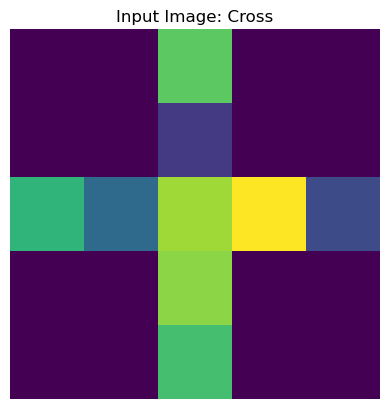

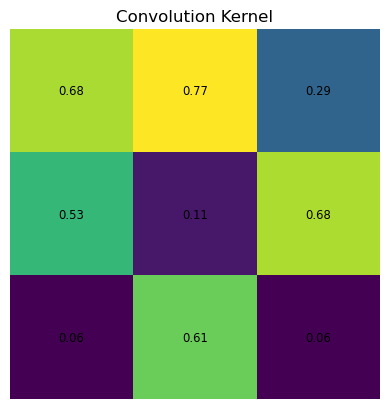

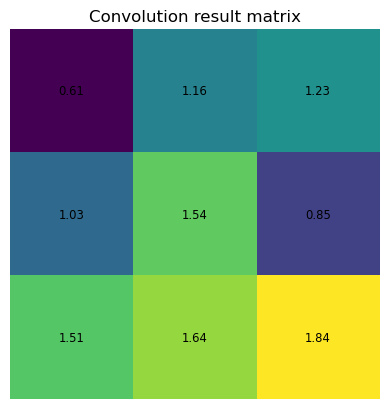

In [3]:
input_img, y = generate_datapoint()
visualize_img(input_img, "Input Image: "+'Cross' if y==0 else 'Rectangle')
visualize_img(conv_vars['conv_kernel'], "Convolution Kernel", num=True)

convolved_mat = convolve(input_img)  # convolve
visualize_img(convolved_mat, "Convolution result matrix", num=True)

#### Pooling
1. The resulting matrix from the convolution operation has size=(3,3). With a stride=1, when we slide a pooling kernel over the input matrix (result of convolution after applying ReLU), it will take 2 strides along each axis to cover the input. The output the operation in each stride is a single, maximum value. Therefore, we will have an output of (4,4) after passing the input to the Pooling Layer. 
2. As mentioned above, the value chosen for the output (2,2) matrix are the respective maximums of each subsection of the input covered by the kernel in the pooling operation.

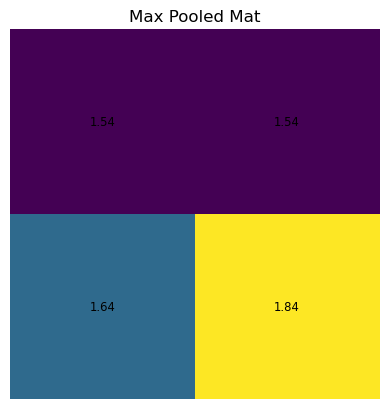

In [4]:
relu_func = np.vectorize(relu)
convolved_mat_relu = relu_func(convolved_mat) # apply relu activation function on output of convolution

# perform pooling
pooled_mat, pool_indices = max_pooling(convolved_mat_relu)
visualize_img(pooled_mat, "Max Pooled Mat", num=True)

#### Fully Connected Layer
1. As this is the last layer of the network, we find the product of the input with their respective weights, add the bias, and get a final, single output value
2. The value is found as
$ (\sum_{i} inputfc_i \cdot w_i) + b $ and is output below

In [5]:
# pass to "fully connected" - only one layer 
input_fc = pooled_mat.flatten()
weights_fc = conv_vars["weights_fc"]
bias = conv_vars["bias_fc"]

z = np.dot(input_fc, weights_fc) + bias
print('Forward propagated value before sigmoid is applied: ', str(z))

Forward propagated value before sigmoid is applied:  2.024779847051223


3. We now apply the sigmoid function and get the final output, and then start backpropagation by applying the chain rule to find the gradient of the loss function L wrt. the weights and bias. By the chain rule: 

$ \frac{dL}{dw} = \frac{dL}{dF} \cdot \frac{dF}{dz} \cdot \frac{dz}{dw}   $ where $ \frac{dz}{dw} = input_{fc} $

$ \frac{dL}{db} = \frac{dL}{dF} \cdot \frac{dF}{dz} \cdot \frac{dz}{db}    $ where $  \frac{dz}{db} = 1 $

In [6]:
F = sigmoid(z)
L = bce(F, y)

#learn_rate = 0.01

dL_dw = d_bce(F,  y)*d_sigmoid(z)*input_fc
dL_db = d_bce(F, y)*d_sigmoid(z)*1
#print(dL_dw)
#print(dL_db)

#update weights
#conv_vars['weights_fc'] -= learn_rate*dL_dw
#conv_vars['bias_fc'] -= learn_rate*dL_db


Next, we backpropagate through the pooling layer, by utilizing indices of max-values found in Max Pooling during forward propagation. This backward pooling of derivatives from the fully connected layer is possible as the max values are the only ones affecting the output/prediction of the network.

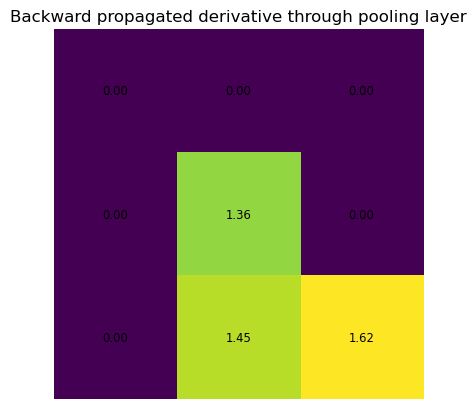

In [7]:

dP =  np.zeros(convolved_mat_relu.shape)
for indices, dw in zip(pool_indices, dL_dw):
    # derivative backpropagated through pooling layer, by using saved indices
    i, j = indices[0], indices[1]
    dP[i, j] = dw
    
visualize_img(dP, 'Backward propagated derivative through pooling layer', num=True)

Now we backpropagate the derivatives through the convolution layer. First, we backpropagate through the ReLU activation function by utilizing the derivative (implemented with the heaviside). This (the result of the convolved matrix through ReLU in forward pass) is multiplied with the gradient backpropagated through the pooling layer.

Then we backpropagate the gradient through the convolution. Backpropagation through the convolution layer can be achieved by convolving the gradient matrix obtained from backwards propagating through the ReLU function on the input. This results in the gradient kernel below, which can be utilized to update the weights of the convolution kernel by means of gradient descent. The bias derivative is found by summing the values of the gradient matrix achieved from last step.

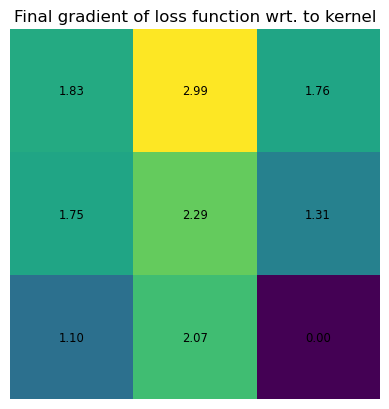

Backward propagated derivative of loss function wrt. to bias:  4.435486426667023


In [8]:
# derivative of relu contribution
d_relu_func = np.vectorize(d_relu)
dR = d_relu_func(convolved_mat) * dP

# derivative of loss wrt. input
dL_dK = convolve(input_img, k=dR) # use convolution to backpropagate derivatives
dL_db = np.sum(dR) # bias term
visualize_img(dL_dK, "Final gradient of loss function wrt. to kernel", num=True)
print("Backward propagated derivative of loss function wrt. to bias: ", dL_db)
# Update weights of convolution layer
#conv_vars['conv_kernel'] -= learn_rate*dL_dF
#conv_vars['conv_bias'] -= learn_rate*dL_db